<h2 style="color:blue" align="center">Quantization Tutorial</h2>

Quantization is a technique to downsize a trained model so that you can deploy it on EDGE devices. In this tutorial we will,

(1) Train a hand written digits model

(2) Export to a disk and check the size of that model

(3) Use two techniques for quantization (1) post training quantization (3) quantization aware training

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
len(X_train)

60000

In [ ]:
len(X_test)

10000

In [ ]:
X_train[0].shape

(28, 28)

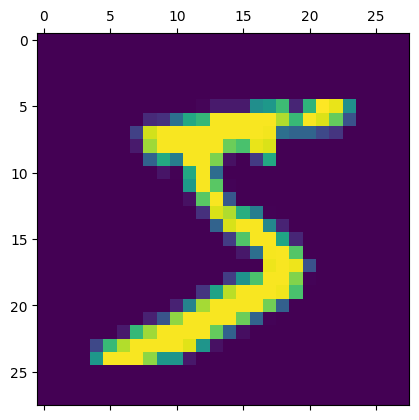

In [ ]:
plt.matshow(X_train[0])

In [ ]:
y_train[0]

5

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [ ]:
X_train_flattened.shape

(60000, 784)

<h3 style='color:purple'>Using Flatten layer so that we don't have to call .reshape on input dataset</h3>

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2734 - accuracy: 0.9216
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1261 - accuracy: 0.9631
Epoch 3/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0871 - accuracy: 0.9740
Epoch 4/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0663 - accuracy: 0.9798
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0516 - accuracy: 0.9843


In [ ]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0777 - accuracy: 0.9747


[0.07773782312870026, 0.9746999740600586]

In [ ]:
model.save("./saved_model/")

In [ ]:
model.save("/content/drive/MyDrive/Stage/Stage Falcon/saved_model")

<h3 style='color:blue'>(1) Post training quantization</h3>

**Without quantization**

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

**With quantization**

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model") # from_saved_model : loading from the disk
converter.optimizations = [tf.lite.Optimize.DEFAULT] # conversion to integer
tflite_quant_model = converter.convert()

Read this article for post training quantization: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

In [ ]:
len(tflite_model)

320004

In [ ]:
len(tflite_quant_model)

84880

You can see above that quantizated model is 1/4th the size of a non quantized model

In [ ]:
with open("tflite_model.tflite", "wb") as f: # wb : write byte mode
    f.write(tflite_model)

In [ ]:
dir="/content/drive/MyDrive/Stage/Stage Falcon/test_model/tflite_model"
filename="tflite_model.tflite"
file_path = dir + '/' + filename
with open(file_path, "wb") as f: # wb : write byte mode
    f.write(tflite_model)

In [ ]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

In [ ]:
dir="/content/drive/MyDrive/Stage/Stage Falcon/test_model/tflite_quant_model"
filename="tflite_quant_model.tflite"
file_path = dir + '/' + filename
with open(file_path, "wb") as f: # wb : write byte mode
    f.write(tflite_model)

Once you have above files saved to a disk, check their sizes. Quantized model will be obvi

<h3 style='color:blue'>(2) Quantization aware training</h3>

In [ ]:
!pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,524
Trainable params: 79,510
Non-traina

In [ ]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 18s 8ms/step - loss: 0.0442 - accuracy: 0.9861


In [ ]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0792 - accuracy: 0.9765


[0.07915342599153519, 0.9764999747276306]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model) # load an in-memory model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
len(tflite_qaware_model)

82736

In [ ]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)

In [ ]:
dir="/content/drive/MyDrive/Stage/Stage Falcon/test_model/tflite_qaware_model"
filename="tflite_qaware_model.tflite"
file_path = dir + '/' + filename
with open(file_path, "wb") as f: # wb : write byte mode
    f.write(tflite_model)

Readling DICOM file

In [1]:
!pip install pydicom matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.3 MB/s eta 0:00:00


In [2]:
import pydicom
import matplotlib.pyplot as plt

In [3]:
ds = pydicom.dcmread("/content/sample_data/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm")

In [4]:
print(ds)
# Access the DICOM metadata

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.1.241740140812485214905427915863105056665
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.0.100.4.0
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 4.0'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.1.241740140812485214905427915863105056665
(0008, 0020) Study Date                          DA: ''
(0008, 0023) Content Date                        DA: '20111229'
(0008, 0030) Stud

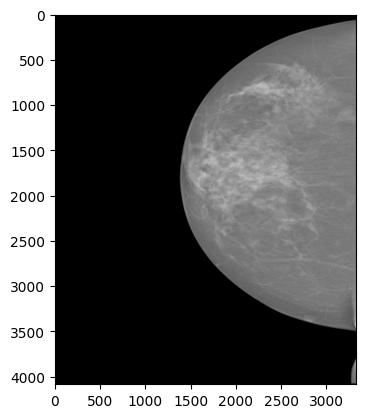

In [8]:
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
plt.show()

Note that DICOM files can contain multiple images in a series. In such cases, you may need to loop through the DICOM files or specify the specific image index to view a particular image.

Additionally, you can use specialized DICOM viewers like RadiAnt DICOM Viewer or OsiriX to visualize DICOM files with more advanced features and capabilities.